# Fine-grained Fruits-360 Pipeline (Handcrafted Features)
This notebook builds classic ML models using handcrafted features (color hist, HOG, LBP, GLCM, Gabor) on the Fruits-360 dataset.

In [8]:
import os
import random
from pathlib import Path

import joblib
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from utils.pipeline_utils import (
    AugmentedDatasetWrapper,
    FruitFolderDataset,
    compute_feature_blocks,
    concat_feature_blocks,
    dataloader_to_numpy,
    download_dataset,
    save_checkpoint,
 )

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [9]:
ROOT_DIR = "dataset/fruit360"
TRAIN_DIR = os.path.join(ROOT_DIR, "Training")
TEST_DIR = os.path.join(ROOT_DIR, "Test")

GITHUB_REPO = "https://github.com/fruits-360/fruits-360-100x100"
CLONE_DIR = "dataset/fruits-360-100x100"

if not os.path.exists(ROOT_DIR):
    download_dataset(ROOT_DIR, TRAIN_DIR, TEST_DIR, GITHUB_REPO, CLONE_DIR)

assert os.path.exists(TRAIN_DIR)
assert os.path.exists(TEST_DIR)

print(f"Train dir: {TRAIN_DIR}")
print(f"Test dir: {TEST_DIR}")

Train dir: dataset/fruit360/Training
Test dir: dataset/fruit360/Test


In [10]:
size = 32
batch = 128
RANDOM_STATE = 42

In [11]:
CKPT_ROOT = Path("artifacts/checkpoints")

In [ ]:
val_transform = T.Compose([
    T.Resize((size, size)),
    T.ToTensor()
])

full_train_dataset_fg = FruitFolderDataset(TRAIN_DIR, transform=val_transform, variety=False)
test_dataset_fg = FruitFolderDataset(TEST_DIR, transform=val_transform, variety=False)

train_size_fg = int(0.7 * len(full_train_dataset_fg))
val_size_fg = len(full_train_dataset_fg) - train_size_fg

train_dataset_fg, val_dataset_fg = random_split(
    full_train_dataset_fg,
    [train_size_fg, val_size_fg],
    generator=torch.Generator().manual_seed(RANDOM_STATE)
)

aug_train_dataset_fg = AugmentedDatasetWrapper(
    train_dataset_fg,
    augment_prob=0.5,
    max_augmentations=2,
    use_scenarios=False,
 )

train_loader_fg = DataLoader(aug_train_dataset_fg, batch_size=batch, shuffle=True)
val_loader_fg = DataLoader(val_dataset_fg, batch_size=batch, shuffle=False)
test_loader_fg = DataLoader(test_dataset_fg, batch_size=batch, shuffle=False)

print("All -> Train:", len(train_dataset_fg),
      "Val:", len(val_dataset_fg),
      "Test:", len(test_dataset_fg),
      "Classes:", len(full_train_dataset_fg.label_to_idx))

Training -> 130344 images, 79 classes
Test -> 43442 images, 79 classes
All -> Train: 91240 Val: 39104 Test: 43442 Classes: 79


In [13]:
X_train_np, y_train_np = dataloader_to_numpy(train_loader_fg)
X_val_np, y_val_np = dataloader_to_numpy(val_loader_fg)
X_test_np, y_test_np = dataloader_to_numpy(test_loader_fg)

print("Train:", X_train_np.shape, y_train_np.shape)
print("Val:", X_val_np.shape, y_val_np.shape)
print("Test:", X_test_np.shape, y_test_np.shape)

Train: (91240, 3, 32, 32) (91240,)
Val: (39104, 3, 32, 32) (39104,)
Test: (43442, 3, 32, 32) (43442,)


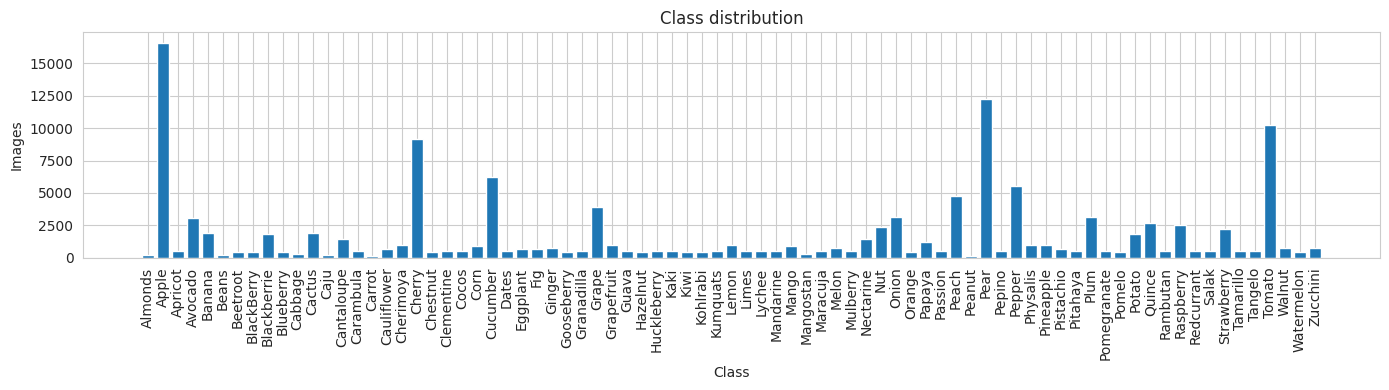

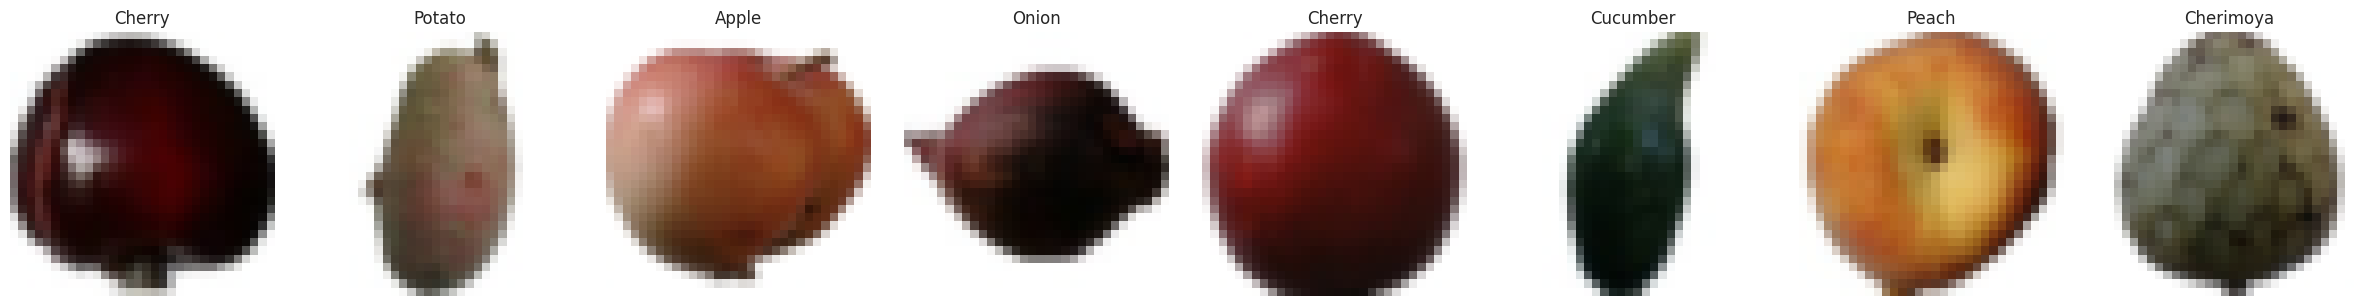

In [14]:
label_counts = {}
for _, lbl in full_train_dataset_fg.samples:
    label_counts[lbl] = label_counts.get(lbl, 0) + 1

labels_sorted = sorted(label_counts.keys())
counts_sorted = [label_counts[l] for l in labels_sorted]

plt.figure(figsize=(14, 4))
plt.bar(labels_sorted, counts_sorted)
plt.title("Class distribution")
plt.xlabel("Class")
plt.ylabel("Images")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Random sample images
n_show = 8
indices = random.sample(range(len(train_dataset_fg)), n_show)
fig, axes = plt.subplots(1, n_show, figsize=(3*n_show, 3))
for ax, idx in zip(axes, indices):
    img, label_idx = train_dataset_fg[idx]
    img_np = img.permute(1, 2, 0).numpy()
    ax.imshow(img_np)
    ax.set_title(full_train_dataset_fg.idx_to_label[int(label_idx)])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [20]:
COLOR_BINS = 32
SPATIAL_GRID = (2, 2)
QUICK_TEST = True  # Set to False per il run completo

In [ ]:
noise_configs = [
    {"name": "noise_base", "augment_prob": 0.2, "max_augmentations": 1, "use_scenarios": True, "scenario_weights": [0.4, 0.4, 0.2]},
]

def make_train_loader(cfg):
    aug_ds = AugmentedDatasetWrapper(
        train_dataset_fg,
        augment_prob=cfg["augment_prob"],
        max_augmentations=cfg["max_augmentations"],
        use_scenarios=cfg["use_scenarios"],
        scenario_weights=cfg.get("scenario_weights"),
    )
    return DataLoader(aug_ds, batch_size=batch, shuffle=True)

val_loader = DataLoader(val_dataset_fg, batch_size=batch, shuffle=False)
test_loader = DataLoader(test_dataset_fg, batch_size=batch, shuffle=False)

X_val_np, y_val = dataloader_to_numpy(val_loader)
X_test_np, y_test = dataloader_to_numpy(test_loader)

feature_sets = {
    "color_hist+hog": ("color_hist", "hog"),
    "color_hist+lbp": ("color_hist", "lbp"),
    "color_hist+glcm": ("color_hist", "glcm"),
    "color_hist+gabor": ("color_hist", "gabor"),
    "color_hist+hog+lbp": ("color_hist", "hog", "lbp"),
}

feature_param_sets = [
    {
        "name": "p",
        "hog": {"pixels_per_cell": (4, 4), "cells_per_block": (2, 2), "orientations": 9},
        "lbp": {"P": 16, "R": 2},
        "glcm": {"distances": (1, 3), "angles": (0, np.pi/2)},
        "gabor": {"frequencies": (0.2, 0.3, 0.4), "thetas": (0, np.pi/4, np.pi/2, 3*np.pi/4)},
    },
]

C_list = [10, 20, 40]

results_grid = []
model_out_root = CKPT_ROOT / "fruit360"
model_out_root.mkdir(parents=True, exist_ok=True)

In [ ]:
# Cache for features (val/test) to avoid expensive recomputations
feature_cache = {}

def _feature_cache_key(split_name, keys, param_cfg):
    return (
        split_name,
        tuple(keys),
        param_cfg["name"],
        size,
        COLOR_BINS,
        SPATIAL_GRID,
    )

def get_feature_blocks_cached(split_name, X_np, keys, param_cfg, use_cache=True):
    cache_key = _feature_cache_key(split_name, keys, param_cfg)
    if use_cache and cache_key in feature_cache:
        return feature_cache[cache_key]
    blocks = compute_feature_blocks(
        X_np,
        img_shape=(3, size, size),
        color_bins=COLOR_BINS,
        spatial_grid=SPATIAL_GRID,
        hog_params=param_cfg["hog"],
        lbp_params=param_cfg["lbp"],
        glcm_params=param_cfg["glcm"],
        gabor_params=param_cfg["gabor"],
        feature_keys=keys,
    )
    if use_cache:
        feature_cache[cache_key] = blocks
    return blocks

def get_features_cached(split_name, X_np, keys, param_cfg, use_cache=True):
    blocks = get_feature_blocks_cached(
        split_name,
        X_np,
        keys,
        param_cfg,
        use_cache=use_cache,
    )
    return concat_feature_blocks(blocks, keys)

In [ ]:
cfg = noise_configs[0]
param_cfg = feature_param_sets[0]
feature_name, keys = next(iter(feature_sets.items()))

print(f"CFG={cfg['name']} | PARAM={param_cfg['name']} | FEATURE={feature_name}")

train_loader_cfg = make_train_loader(cfg)
X_train_np, y_train = dataloader_to_numpy(train_loader_cfg)

print("[VAL features]")
X_val_feat = get_features_cached(
    "val",
    X_val_np,
    keys,
    param_cfg,
 )
print("[TEST features]")
X_test_feat = get_features_cached(
    "test",
    X_test_np,
    keys,
    param_cfg,
 )
print("[TRAIN features]")
X_train_feat = get_features_cached(
    f"train:{cfg['name']}",
    X_train_np,
    keys,
    param_cfg,
    use_cache=False,
 )

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_feat)
X_val_std = scaler.transform(X_val_feat)
X_test_std = scaler.transform(X_test_feat)

meta_base = {
    "task": "fruit360",
    "split": "All",
    "feature": feature_name,
    "feature_keys": keys,
    "feature_param_set": param_cfg["name"],
    "feature_params": param_cfg,
    "img_size": size,
    "bins": COLOR_BINS,
    "spatial_grid": SPATIAL_GRID,
    "seed": RANDOM_STATE,
    "n_classes": len(full_train_dataset_fg.label_to_idx),
    "labels": full_train_dataset_fg.labels,
    "label_to_idx": full_train_dataset_fg.label_to_idx,
    "noise_cfg": cfg,
}

# SVM
best_svm_acc = 0.0
best_C = None
best_svm_model = None
for C in C_list:
    svm = SVC(kernel="rbf", gamma="scale", C=C)
    svm.fit(X_train_std, y_train)
    y_val_pred = svm.predict(X_val_std)
    acc = accuracy_score(y_val, y_val_pred)
    if acc > best_svm_acc:
        best_svm_acc = acc
        best_C = C
        best_svm_model = svm
        print(f"  [SVM] new best C={best_C} val_acc={best_svm_acc:.4f}")
if best_svm_model is not None:
    y_test_pred = best_svm_model.predict(X_test_std)
    test_acc = accuracy_score(y_test, y_test_pred)
    run_dir = model_out_root / cfg["name"] / param_cfg["name"] / feature_name / "svm"
    save_checkpoint(
        best_svm_model,
        scaler,
        {**meta_base, "model": f"svm-{cfg['name']}", "params": {"kernel": "rbf", "C": best_C, "gamma": "scale"}},
        run_dir=run_dir,
        save_meta=False,
    )
    results_grid.append({"cfg": cfg["name"], "param": param_cfg["name"], "feature": feature_name, "model": "svm", "val_acc": best_svm_acc, "test_acc": test_acc})

results_df = pd.DataFrame(results_grid)
if not results_df.empty:
    results_df = results_df.sort_values(["test_acc", "val_acc"], ascending=False)
results_df

CFG=noise_base | PARAM=p1 | FEATURE=color_hist+hog
[VAL blocks]
[TEST blocks]
[TRAIN blocks]
  [SVM] new best C=10 val_acc=0.9999


,cfg,param,feature,model,val_acc,test_acc
0,noise_base,p1,color_hist+hog,svm,0.999872,0.968878


In [ ]:
cfg = noise_configs[0]
param_cfg = feature_param_sets[0]
feature_items = list(feature_sets.items())
feature_name, keys = feature_items[1] if len(feature_items) > 1 else feature_items[0]

print(f"CFG={cfg['name']} | PARAM={param_cfg['name']} | FEATURE={feature_name}")

train_loader_cfg = make_train_loader(cfg)
X_train_np, y_train = dataloader_to_numpy(train_loader_cfg)

print("[VAL features]")
X_val_feat = get_features_cached(
    "val",
    X_val_np,
    keys,
    param_cfg,
 )
print("[TEST features]")
X_test_feat = get_features_cached(
    "test",
    X_test_np,
    keys,
    param_cfg,
 )
print("[TRAIN features]")
X_train_feat = get_features_cached(
    f"train:{cfg['name']}",
    X_train_np,
    keys,
    param_cfg,
    use_cache=False,
 )

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_feat)
X_val_std = scaler.transform(X_val_feat)
X_test_std = scaler.transform(X_test_feat)

meta_base = {
    "task": "fruit360",
    "split": "All",
    "feature": feature_name,
    "feature_keys": keys,
    "feature_param_set": param_cfg["name"],
    "feature_params": param_cfg,
    "img_size": size,
    "bins": COLOR_BINS,
    "spatial_grid": SPATIAL_GRID,
    "seed": RANDOM_STATE,
    "n_classes": len(full_train_dataset_fg.label_to_idx),
    "labels": full_train_dataset_fg.labels,
    "label_to_idx": full_train_dataset_fg.label_to_idx,
    "noise_cfg": cfg,
}

# SVM
best_svm_acc = 0.0
best_C = None
best_svm_model = None
for C in C_list:
    svm = SVC(kernel="rbf", gamma="scale", C=C)
    svm.fit(X_train_std, y_train)
    y_val_pred = svm.predict(X_val_std)
    acc = accuracy_score(y_val, y_val_pred)
    if acc > best_svm_acc:
        best_svm_acc = acc
        best_C = C
        best_svm_model = svm
        print(f"  [SVM] new best C={best_C} val_acc={best_svm_acc:.4f}")
if best_svm_model is not None:
    y_test_pred = best_svm_model.predict(X_test_std)
    test_acc = accuracy_score(y_test, y_test_pred)
    run_dir = model_out_root / cfg["name"] / param_cfg["name"] / feature_name / "svm"
    save_checkpoint(
        best_svm_model,
        scaler,
        {**meta_base, "model": f"svm-{cfg['name']}", "params": {"kernel": "rbf", "C": best_C, "gamma": "scale"}},
        run_dir=run_dir,
        save_meta=False,
    )
    results_grid.append({"cfg": cfg["name"], "param": param_cfg["name"], "feature": feature_name, "model": "svm", "val_acc": best_svm_acc, "test_acc": test_acc})

results_df = pd.DataFrame(results_grid)
if not results_df.empty:
    results_df = results_df.sort_values(["test_acc", "val_acc"], ascending=False)
results_df

CFG=noise_base | PARAM=p2 | FEATURE=color_hist+lbp
[VAL blocks]


/home/leo/Documents/repo/Ml_Project/venv/lib/python3.14/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


[TEST blocks]
[TRAIN blocks]
  [SVM] new best C=10 val_acc=0.9999
  [SVM] new best C=20 val_acc=0.9999
  [SVM] new best C=40 val_acc=1.0000


,cfg,param,feature,model,val_acc,test_acc
0,noise_base,p2,color_hist+lbp,svm,0.999974,0.985728


In [ ]:
cfg = noise_configs[0]
param_cfg = feature_param_sets[0]
feature_items = list(feature_sets.items())
feature_name, keys = feature_items[2] if len(feature_items) > 2 else feature_items[0]

print(f"CFG={cfg['name']} | PARAM={param_cfg['name']} | FEATURE={feature_name}")

train_loader_cfg = make_train_loader(cfg)
X_train_np, y_train = dataloader_to_numpy(train_loader_cfg)

print("[VAL features]")
X_val_feat = get_features_cached(
    "val",
    X_val_np,
    keys,
    param_cfg,
 )
print("[TEST features]")
X_test_feat = get_features_cached(
    "test",
    X_test_np,
    keys,
    param_cfg,
 )
print("[TRAIN features]")
X_train_feat = get_features_cached(
    f"train:{cfg['name']}",
    X_train_np,
    keys,
    param_cfg,
    use_cache=False,
 )

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_feat)
X_val_std = scaler.transform(X_val_feat)
X_test_std = scaler.transform(X_test_feat)

meta_base = {
    "task": "fruit360",
    "split": "All",
    "feature": feature_name,
    "feature_keys": keys,
    "feature_param_set": param_cfg["name"],
    "feature_params": param_cfg,
    "img_size": size,
    "bins": COLOR_BINS,
    "spatial_grid": SPATIAL_GRID,
    "seed": RANDOM_STATE,
    "n_classes": len(full_train_dataset_fg.label_to_idx),
    "labels": full_train_dataset_fg.labels,
    "label_to_idx": full_train_dataset_fg.label_to_idx,
    "noise_cfg": cfg,
}

# SVM
best_svm_acc = 0.0
best_C = None
best_svm_model = None
for C in C_list:
    svm = SVC(kernel="rbf", gamma="scale", C=C)
    svm.fit(X_train_std, y_train)
    y_val_pred = svm.predict(X_val_std)
    acc = accuracy_score(y_val, y_val_pred)
    if acc > best_svm_acc:
        best_svm_acc = acc
        best_C = C
        best_svm_model = svm
        print(f"  [SVM] new best C={best_C} val_acc={best_svm_acc:.4f}")
if best_svm_model is not None:
    y_test_pred = best_svm_model.predict(X_test_std)
    test_acc = accuracy_score(y_test, y_test_pred)
    run_dir = model_out_root / cfg["name"] / param_cfg["name"] / feature_name / "svm"
    save_checkpoint(
        best_svm_model,
        scaler,
        {**meta_base, "model": f"svm-{cfg['name']}", "params": {"kernel": "rbf", "C": best_C, "gamma": "scale"}},
        run_dir=run_dir,
        save_meta=False,
    )
    results_grid.append({"cfg": cfg["name"], "param": param_cfg["name"], "feature": feature_name, "model": "svm", "val_acc": best_svm_acc, "test_acc": test_acc})

results_df = pd.DataFrame(results_grid)
if not results_df.empty:
    results_df = results_df.sort_values(["test_acc", "val_acc"], ascending=False)
results_df

CFG=noise_base | PARAM=p2 | FEATURE=color_hist+glcm
[VAL blocks]
[TEST blocks]
[TRAIN blocks]
  [SVM] new best C=10 val_acc=0.9998
  [SVM] new best C=20 val_acc=0.9999


,cfg,param,feature,model,val_acc,test_acc
1,noise_base,p2,color_hist+glcm,svm,0.999949,0.986557
0,noise_base,p2,color_hist+lbp,svm,0.999974,0.985728


In [ ]:
cfg = noise_configs[0]
param_cfg = feature_param_sets[0]
feature_items = list(feature_sets.items())
feature_name, keys = feature_items[3] if len(feature_items) > 3 else feature_items[0]

print(f"CFG={cfg['name']} | PARAM={param_cfg['name']} | FEATURE={feature_name}")

train_loader_cfg = make_train_loader(cfg)
X_train_np, y_train = dataloader_to_numpy(train_loader_cfg)

print("[VAL features]")
X_val_feat = get_features_cached(
    "val",
    X_val_np,
    keys,
    param_cfg,
 )
print("[TEST features]")
X_test_feat = get_features_cached(
    "test",
    X_test_np,
    keys,
    param_cfg,
 )
print("[TRAIN features]")
X_train_feat = get_features_cached(
    f"train:{cfg['name']}",
    X_train_np,
    keys,
    param_cfg,
    use_cache=False,
 )

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_feat)
X_val_std = scaler.transform(X_val_feat)
X_test_std = scaler.transform(X_test_feat)

meta_base = {
    "task": "fruit360",
    "split": "All",
    "feature": feature_name,
    "feature_keys": keys,
    "feature_param_set": param_cfg["name"],
    "feature_params": param_cfg,
    "img_size": size,
    "bins": COLOR_BINS,
    "spatial_grid": SPATIAL_GRID,
    "seed": RANDOM_STATE,
    "n_classes": len(full_train_dataset_fg.label_to_idx),
    "labels": full_train_dataset_fg.labels,
    "label_to_idx": full_train_dataset_fg.label_to_idx,
    "noise_cfg": cfg,
}

# SVM
best_svm_acc = 0.0
best_C = None
best_svm_model = None
for C in C_list:
    svm = SVC(kernel="rbf", gamma="scale", C=C)
    svm.fit(X_train_std, y_train)
    y_val_pred = svm.predict(X_val_std)
    acc = accuracy_score(y_val, y_val_pred)
    if acc > best_svm_acc:
        best_svm_acc = acc
        best_C = C
        best_svm_model = svm
        print(f"  [SVM] new best C={best_C} val_acc={best_svm_acc:.4f}")
if best_svm_model is not None:
    y_test_pred = best_svm_model.predict(X_test_std)
    test_acc = accuracy_score(y_test, y_test_pred)
    run_dir = model_out_root / cfg["name"] / param_cfg["name"] / feature_name / "svm"
    save_checkpoint(
        best_svm_model,
        scaler,
        {**meta_base, "model": f"svm-{cfg['name']}", "params": {"kernel": "rbf", "C": best_C, "gamma": "scale"}},
        run_dir=run_dir,
        save_meta=False,
    )
    results_grid.append({"cfg": cfg["name"] , "param": param_cfg["name"], "feature": feature_name, "model": "svm", "val_acc": best_svm_acc, "test_acc": test_acc})

results_df = pd.DataFrame(results_grid)
if not results_df.empty:
    results_df = results_df.sort_values(["test_acc", "val_acc"], ascending=False)
results_df

CFG=noise_base | PARAM=p2 | FEATURE=color_hist+gabor
[VAL blocks]
[TEST blocks]
[TRAIN blocks]
  [SVM] new best C=10 val_acc=0.9999


,cfg,param,feature,model,val_acc,test_acc
0,noise_base,p2,color_hist+gabor,svm,0.999872,0.989941


In [ ]:
# PCA color_hist + gabor
cfg = noise_configs[0]
param_cfg = feature_param_sets[0]
feature_name = "color_hist+gabor"
keys = ("color_hist", "gabor")

PCA_N_COMPONENTS = 0.95  
print(f"CFG={cfg['name']} | PARAM={param_cfg['name']} | FEATURE={feature_name} | PCA={PCA_N_COMPONENTS}")

train_loader_cfg = make_train_loader(cfg)
X_train_np, y_train = dataloader_to_numpy(train_loader_cfg)

print("[VAL features]")
X_val_feat = get_features_cached(
    "val",
    X_val_np,
    keys,
    param_cfg,
 )
print("[TEST features]")
X_test_feat = get_features_cached(
    "test",
    X_test_np,
    keys,
    param_cfg,
 )
print("[TRAIN features]")
X_train_feat = get_features_cached(
    f"train:{cfg['name']}",
    X_train_np,
    keys,
    param_cfg,
    use_cache=False,
 )

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_feat)
X_val_std = scaler.transform(X_val_feat)
X_test_std = scaler.transform(X_test_feat)

pca = PCA(n_components=PCA_N_COMPONENTS, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_std)
X_val_pca = pca.transform(X_val_std)
X_test_pca = pca.transform(X_test_std)

meta_base = {
    "task": "fruit360",
    "split": "All",
    "feature": feature_name,
    "feature_keys": keys,
    "feature_param_set": param_cfg["name"],
    "feature_params": param_cfg,
    "img_size": size,
    "bins": COLOR_BINS,
    "spatial_grid": SPATIAL_GRID,
    "seed": RANDOM_STATE,
    "n_classes": len(full_train_dataset_fg.label_to_idx),
    "labels": full_train_dataset_fg.labels,
    "label_to_idx": full_train_dataset_fg.label_to_idx,
    "noise_cfg": cfg,
    "pca": PCA_N_COMPONENTS,
    "pca_n_components": int(pca.n_components_),
    "pca_var_ratio": float(pca.explained_variance_ratio_.sum()),
}

# SVM PCA
best_svm_acc = 0.0
best_C = None
best_svm_model = None
for C in C_list:
    svm = SVC(kernel="rbf", gamma="scale", C=C)
    svm.fit(X_train_pca, y_train)
    y_val_pred = svm.predict(X_val_pca)
    acc = accuracy_score(y_val, y_val_pred)
    if acc > best_svm_acc:
        best_svm_acc = acc
        best_C = C
        best_svm_model = svm
        print(f"  [SVM+PCA] new best C={best_C} val_acc={best_svm_acc:.4f}")
if best_svm_model is not None:
    y_test_pred = best_svm_model.predict(X_test_pca)
    test_acc = accuracy_score(y_test, y_test_pred)
    run_dir = model_out_root / cfg["name"] / param_cfg["name"] / feature_name / "svm_pca"
    run_dir = save_checkpoint(
        best_svm_model,
        scaler,
        {**meta_base, "model": f"svm-pca-{cfg['name']}", "params": {"kernel": "rbf", "C": best_C, "gamma": "scale"}},
        run_dir=run_dir,
        save_meta=False,
    )
    joblib.dump(pca, run_dir / "pca.joblib")
    results_grid.append({"cfg": cfg["name"], "param": param_cfg["name"], "feature": feature_name, "model": "svm_pca", "val_acc": best_svm_acc, "test_acc": test_acc})

results_df = pd.DataFrame(results_grid)
if not results_df.empty:
    results_df = results_df.sort_values(["test_acc", "val_acc"], ascending=False)
results_df

CFG=noise_base | PARAM=p | FEATURE=color_hist+gabor | PCA=0.95
[VAL features]
[TEST features]
[TRAIN features]
  [SVM+PCA] new best C=10 val_acc=1.0000


,cfg,param,feature,model,val_acc,test_acc
1,noise_base,p,color_hist+gabor,svm_pca,0.999974,0.991138
0,noise_base,p,color_hist+gabor,svm_pca,0.999949,0.989319


In [ ]:
cfg = noise_configs[0]
param_cfg = feature_param_sets[0]
feature_items = list(feature_sets.items())
feature_name, keys = feature_items[4] if len(feature_items) > 4 else feature_items[0]

print(f"CFG={cfg['name']} | PARAM={param_cfg['name']} | FEATURE={feature_name}")

train_loader_cfg = make_train_loader(cfg)
X_train_np, y_train = dataloader_to_numpy(train_loader_cfg)

print("[VAL features]")
X_val_feat = get_features_cached(
    "val",
    X_val_np,
    keys,
    param_cfg,
 )
print("[TEST features]")
X_test_feat = get_features_cached(
    "test",
    X_test_np,
    keys,
    param_cfg,
 )
print("[TRAIN features]")
X_train_feat = get_features_cached(
    f"train:{cfg['name']}",
    X_train_np,
    keys,
    param_cfg,
    use_cache=False,
 )

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_feat)
X_val_std = scaler.transform(X_val_feat)
X_test_std = scaler.transform(X_test_feat)

meta_base = {
    "task": "fruit360",
    "split": "All",
    "feature": feature_name,
    "feature_keys": keys,
    "feature_param_set": param_cfg["name"],
    "feature_params": param_cfg,
    "img_size": size,
    "bins": COLOR_BINS,
    "spatial_grid": SPATIAL_GRID,
    "seed": RANDOM_STATE,
    "n_classes": len(full_train_dataset_fg.label_to_idx),
    "labels": full_train_dataset_fg.labels,
    "label_to_idx": full_train_dataset_fg.label_to_idx,
    "noise_cfg": cfg,
}

# SVM
best_svm_acc = 0.0
best_C = None
best_svm_model = None
for C in C_list:
    svm = SVC(kernel="rbf", gamma="scale", C=C)
    svm.fit(X_train_std, y_train)
    y_val_pred = svm.predict(X_val_std)
    acc = accuracy_score(y_val, y_val_pred)
    if acc > best_svm_acc:
        best_svm_acc = acc
        best_C = C
        best_svm_model = svm
        print(f"  [SVM] new best C={best_C} val_acc={best_svm_acc:.4f}")
if best_svm_model is not None:
    y_test_pred = best_svm_model.predict(X_test_std)
    test_acc = accuracy_score(y_test, y_test_pred)
    run_dir = model_out_root / cfg["name"] / param_cfg["name"] / feature_name / "svm"
    save_checkpoint(
        best_svm_model,
        scaler,
        {**meta_base, "model": f"svm-{cfg['name']}", "params": {"kernel": "rbf", "C": best_C, "gamma": "scale"}},
        run_dir=run_dir,
        save_meta=False,
    )
    results_grid.append({"cfg": cfg["name"], "param": param_cfg["name"], "feature": feature_name, "model": "svm", "val_acc": best_svm_acc, "test_acc": test_acc})

results_df = pd.DataFrame(results_grid)
if not results_df.empty:
    results_df = results_df.sort_values(["test_acc", "val_acc"], ascending=False)
results_df